<a href="https://colab.research.google.com/github/ShriramGithub7/EVA8_S5_Batch_Normalization_-_Regularization/blob/main/EVA8_Session_5_Batch_Normalization_%26_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive, load model.py file and create model object

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Load the model.py file

In [18]:
!cp /content/drive/MyDrive/mymodel.py .


Create model object

In [19]:
import mymodel
model = mymodel.Net()

# Import libraries

In [20]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function

# Find mean and std deviation of the data

In [21]:
testing_transofrms = transforms.Compose([transforms.ToTensor()])
exp= datasets.MNIST('.data/', train=True, download=True, transform=testing_transofrms)
exp_data = exp.train_data
exp_data=exp.transform(exp_data.numpy())


In [22]:
print('shape - ', exp_data.shape)
print('size - ', exp_data.size())
print('min - ', exp_data.min())
print('max - ', exp_data.max())
print('mean - ', exp_data.mean())
print('std - ', exp_data.std())
print('var - ', exp_data.var())

shape -  torch.Size([28, 60000, 28])
size -  torch.Size([28, 60000, 28])
min -  tensor(0.)
max -  tensor(1.)
mean -  tensor(0.1307)
std -  tensor(0.3081)
var -  tensor(0.0949)


# Data transformation

In [23]:
#training data transormation

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(255,))
                                      ])

#testing data transformation
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

# Load data, split it in train/test and apply transform 

In [24]:
train = datasets.MNIST('.data/', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('.data/', train=False, download = True, transform=test_transforms)

# Dataloader arguments and Train/Test Dataloaders

In [25]:
from torch.utils.data import dataloader
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available - ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader=torch.utils.data.DataLoader(train, **dataloader_args)

test_loader=torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available -  True


# View few images

torch.Size([128, 1, 28, 28])
torch.Size([128])


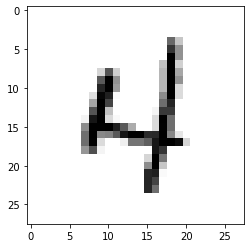

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

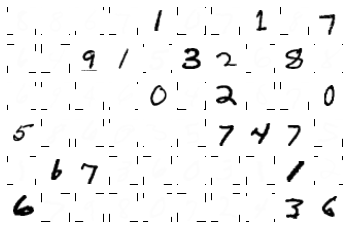

In [27]:
figure = plt.figure()
num_of_images=60
for index in range (1, num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')



In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


# Training and Testing - Group Normalization

In [29]:
model = mymodel.Net()

In [30]:
from tqdm import tqdm

train_losses_group = []
test_losses_group = []
train_acc_group = []
test_acc_group = []
type_of_norm = 'gn'

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_group.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_group.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_group = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses_group.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_group.append(100. * correct / len(test_loader.dataset))

# Train the model for Group Normalization


In [31]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
#model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6361541152000427 Batch_id=468 Accuracy=52.78: 100%|██████████| 469/469 [00:37<00:00, 12.48it/s]



Test set: Average loss: 0.4780, Accuracy: 8687/10000 (86.87%)

EPOCH: 1


Loss=0.22448277473449707 Batch_id=468 Accuracy=90.50: 100%|██████████| 469/469 [00:30<00:00, 15.32it/s]



Test set: Average loss: 0.1355, Accuracy: 9671/10000 (96.71%)

EPOCH: 2


Loss=0.12045296281576157 Batch_id=468 Accuracy=95.01: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]



Test set: Average loss: 0.0912, Accuracy: 9754/10000 (97.54%)

EPOCH: 3


Loss=0.10250366479158401 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]



Test set: Average loss: 0.0768, Accuracy: 9777/10000 (97.77%)

EPOCH: 4


Loss=0.17909324169158936 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]



Test set: Average loss: 0.0586, Accuracy: 9839/10000 (98.39%)

EPOCH: 5


Loss=0.09586691111326218 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]



Test set: Average loss: 0.0579, Accuracy: 9842/10000 (98.42%)

EPOCH: 6


Loss=0.06688539683818817 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s]



Test set: Average loss: 0.0568, Accuracy: 9846/10000 (98.46%)

EPOCH: 7


Loss=0.06373579800128937 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]



Test set: Average loss: 0.0531, Accuracy: 9849/10000 (98.49%)

EPOCH: 8


Loss=0.04934915900230408 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s]



Test set: Average loss: 0.0523, Accuracy: 9856/10000 (98.56%)

EPOCH: 9


Loss=0.055248986929655075 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]



Test set: Average loss: 0.0523, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


Loss=0.1532980054616928 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]



Test set: Average loss: 0.0520, Accuracy: 9858/10000 (98.58%)

EPOCH: 11


Loss=0.06959110498428345 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:30<00:00, 15.21it/s]



Test set: Average loss: 0.0523, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.15658292174339294 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]



Test set: Average loss: 0.0521, Accuracy: 9855/10000 (98.55%)

EPOCH: 13


Loss=0.04076695442199707 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]



Test set: Average loss: 0.0521, Accuracy: 9857/10000 (98.57%)

EPOCH: 14


Loss=0.05112069472670555 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.0521, Accuracy: 9856/10000 (98.56%)

EPOCH: 15


Loss=0.0670083686709404 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:31<00:00, 15.06it/s]



Test set: Average loss: 0.0520, Accuracy: 9857/10000 (98.57%)

EPOCH: 16


Loss=0.16821514070034027 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]



Test set: Average loss: 0.0520, Accuracy: 9857/10000 (98.57%)

EPOCH: 17


Loss=0.039854954928159714 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:29<00:00, 15.64it/s]



Test set: Average loss: 0.0520, Accuracy: 9857/10000 (98.57%)

EPOCH: 18


Loss=0.11110485345125198 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:30<00:00, 15.44it/s]



Test set: Average loss: 0.0520, Accuracy: 9857/10000 (98.57%)

EPOCH: 19


Loss=0.09852883219718933 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:30<00:00, 15.55it/s]



Test set: Average loss: 0.0520, Accuracy: 9857/10000 (98.57%)



# Training and Testing - Layer Normalization

In [32]:
from tqdm import tqdm

train_losses_layer = []
test_losses_layer = []
train_acc_layer = []
test_acc_layer = []
type_of_norm = 'ln'

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_layer.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_layer.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses_layer.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_layer.append(100. * correct / len(test_loader.dataset))

# Train the model for Layer Normalization


In [33]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.8381774425506592 Batch_id=468 Accuracy=34.77: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]



Test set: Average loss: 0.7788, Accuracy: 8222/10000 (82.22%)

EPOCH: 1


Loss=0.536220371723175 Batch_id=468 Accuracy=86.25: 100%|██████████| 469/469 [00:30<00:00, 15.45it/s]



Test set: Average loss: 0.1768, Accuracy: 9555/10000 (95.55%)

EPOCH: 2


Loss=0.2770744264125824 Batch_id=468 Accuracy=92.42: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]



Test set: Average loss: 0.1188, Accuracy: 9685/10000 (96.85%)

EPOCH: 3


Loss=0.10451389104127884 Batch_id=468 Accuracy=93.93: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]



Test set: Average loss: 0.1005, Accuracy: 9716/10000 (97.16%)

EPOCH: 4


Loss=0.13494324684143066 Batch_id=468 Accuracy=95.32: 100%|██████████| 469/469 [00:30<00:00, 15.29it/s]



Test set: Average loss: 0.0818, Accuracy: 9768/10000 (97.68%)

EPOCH: 5


Loss=0.18205611407756805 Batch_id=468 Accuracy=95.68: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s]



Test set: Average loss: 0.0762, Accuracy: 9778/10000 (97.78%)

EPOCH: 6


Loss=0.0859673023223877 Batch_id=468 Accuracy=95.86: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.0754, Accuracy: 9788/10000 (97.88%)

EPOCH: 7


Loss=0.1554224193096161 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:30<00:00, 15.41it/s]



Test set: Average loss: 0.0747, Accuracy: 9779/10000 (97.79%)

EPOCH: 8


Loss=0.10367237776517868 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:30<00:00, 15.45it/s]



Test set: Average loss: 0.0728, Accuracy: 9790/10000 (97.90%)

EPOCH: 9


Loss=0.13526701927185059 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s]



Test set: Average loss: 0.0725, Accuracy: 9791/10000 (97.91%)

EPOCH: 10


Loss=0.09238352626562119 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:30<00:00, 15.54it/s]



Test set: Average loss: 0.0723, Accuracy: 9793/10000 (97.93%)

EPOCH: 11


Loss=0.12384525686502457 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:30<00:00, 15.34it/s]



Test set: Average loss: 0.0716, Accuracy: 9792/10000 (97.92%)

EPOCH: 12


Loss=0.16014167666435242 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:30<00:00, 15.47it/s]



Test set: Average loss: 0.0717, Accuracy: 9792/10000 (97.92%)

EPOCH: 13


Loss=0.10874847322702408 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]



Test set: Average loss: 0.0717, Accuracy: 9791/10000 (97.91%)

EPOCH: 14


Loss=0.042490649968385696 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:30<00:00, 15.25it/s]



Test set: Average loss: 0.0718, Accuracy: 9789/10000 (97.89%)

EPOCH: 15


Loss=0.12329066544771194 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s]



Test set: Average loss: 0.0719, Accuracy: 9788/10000 (97.88%)

EPOCH: 16


Loss=0.11479946970939636 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:30<00:00, 15.42it/s]



Test set: Average loss: 0.0719, Accuracy: 9788/10000 (97.88%)

EPOCH: 17


Loss=0.18256346881389618 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]



Test set: Average loss: 0.0719, Accuracy: 9789/10000 (97.89%)

EPOCH: 18


Loss=0.0918024480342865 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]



Test set: Average loss: 0.0719, Accuracy: 9789/10000 (97.89%)

EPOCH: 19


Loss=0.0918445959687233 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]



Test set: Average loss: 0.0719, Accuracy: 9789/10000 (97.89%)



 # Training and Testing - Batch Normalization and L1 Regularization

In [34]:
from tqdm import tqdm

train_losses_batch = []
test_losses_batch = []
train_acc_batch = []
test_acc_batch = []
type_of_norm = 'bn'

mse=nn.MSELoss()
lambda_l1 = 0.01


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    target=target.float().unsqueeze(dim=1)

    loss = mse(y_pred, target)
    l1 = 0
    for p in model.parameters():
      l1 = l1 + p.abs().sum()
    loss = loss + lambda_l1 * l1
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_batch.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassiffied = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            target=target.float().unsqueeze(dim=1)
            test_loss += mse(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses_batch.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_batch.append(100. * correct / len(test_loader.dataset))


# Train the model for Batch Normalization and L1 Regularization

In [35]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss=53.36402130126953 Batch_id=467 Accuracy=9.65: 100%|█████████▉| 468/469 [00:32<00:00, 20.38it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss=52.04801559448242 Batch_id=468 Accuracy=9.65: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.p


Test set: Average loss: 0.4248, Accuracy: 980/10000 (9.80%)

EPOCH: 1


Loss=49.65608596801758 Batch_id=468 Accuracy=9.99: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]



Test set: Average loss: 0.4250, Accuracy: 980/10000 (9.80%)

EPOCH: 2


Loss=53.28642272949219 Batch_id=468 Accuracy=9.97: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]



Test set: Average loss: 0.4257, Accuracy: 980/10000 (9.80%)

EPOCH: 3


Loss=57.62498474121094 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]



Test set: Average loss: 0.4261, Accuracy: 980/10000 (9.80%)

EPOCH: 4


Loss=56.8648681640625 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.97it/s]



Test set: Average loss: 0.4256, Accuracy: 980/10000 (9.80%)

EPOCH: 5


Loss=60.09457778930664 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]



Test set: Average loss: 0.4257, Accuracy: 980/10000 (9.80%)

EPOCH: 6


Loss=47.66484451293945 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]



Test set: Average loss: 0.4253, Accuracy: 980/10000 (9.80%)

EPOCH: 7


Loss=53.66343307495117 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 15.13it/s]



Test set: Average loss: 0.4273, Accuracy: 980/10000 (9.80%)

EPOCH: 8


Loss=53.216365814208984 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.4252, Accuracy: 980/10000 (9.80%)

EPOCH: 9


Loss=45.884986877441406 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 15.11it/s]



Test set: Average loss: 0.4258, Accuracy: 980/10000 (9.80%)

EPOCH: 10


Loss=51.09905242919922 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]



Test set: Average loss: 0.4259, Accuracy: 980/10000 (9.80%)

EPOCH: 11


Loss=51.37373352050781 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]



Test set: Average loss: 0.4275, Accuracy: 980/10000 (9.80%)

EPOCH: 12


Loss=48.118431091308594 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]



Test set: Average loss: 0.4286, Accuracy: 980/10000 (9.80%)

EPOCH: 13


Loss=58.88043212890625 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 15.09it/s]



Test set: Average loss: 0.4259, Accuracy: 980/10000 (9.80%)

EPOCH: 14


Loss=51.51176834106445 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]



Test set: Average loss: 0.4252, Accuracy: 980/10000 (9.80%)

EPOCH: 15


Loss=59.72718048095703 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]



Test set: Average loss: 0.4259, Accuracy: 980/10000 (9.80%)

EPOCH: 16


Loss=52.1455192565918 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]



Test set: Average loss: 0.4268, Accuracy: 980/10000 (9.80%)

EPOCH: 17


Loss=58.160011291503906 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]



Test set: Average loss: 0.4261, Accuracy: 980/10000 (9.80%)

EPOCH: 18


Loss=53.44129943847656 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]



Test set: Average loss: 0.4249, Accuracy: 980/10000 (9.80%)

EPOCH: 19


Loss=56.334102630615234 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]



Test set: Average loss: 0.4237, Accuracy: 980/10000 (9.80%)



# Plot graphs

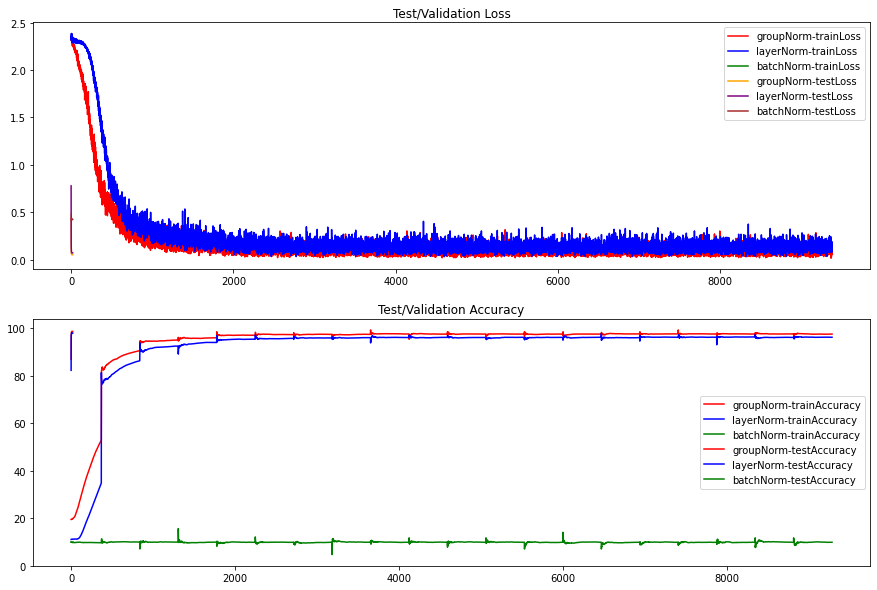

In [39]:
fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(train_losses_group, color='red', label='groupNorm-trainLoss')
axs[0].plot(train_losses_layer, color='blue', label='layerNorm-trainLoss')
axs[0].plot(train_losses_batch, color='green', label='batchNorm-trainLoss')

axs[0].plot(test_losses_group, color='orange', label='groupNorm-testLoss')
axs[0].plot(test_losses_layer, color='purple', label='layerNorm-testLoss')
axs[0].plot(test_losses_batch, color='brown', label='batchNorm-testLoss')
axs[0].set_title("Test/Validation Loss")
axs[0].legend()

axs[1].plot(train_acc_group[100:], color='r', label='groupNorm-trainAccuracy')
axs[1].plot(train_acc_layer[100:], color='b', label='layerNorm-trainAccuracy')
axs[1].plot(train_acc_batch[100:], color='g', label='batchNorm-trainAccuracy')

axs[1].plot(test_acc_group, color='r', label='groupNorm-testAccuracy')
axs[1].plot(test_acc_layer, color='b', label='layerNorm-testAccuracy')
axs[1].plot(test_acc_batch, color='g', label='batchNorm-testAccuracy')
axs[1].set_title("Test/Validation Accuracy")
axs[1].legend()
